## 1. Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
import math
import io
import os

from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.auto import tqdm

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMAGE_SIZE = 256
HEATMAP_SIZE = 64
TRAIN = True

## 2. Загрузка датасета

In [3]:
# Загрузка тренировочного датасета
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/n2kAPJWC9McroQ) -o train_dataset.zip
! unzip -qq train_dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 1214M  100 1214M    0     0  13.3M      0  0:01:30  0:01:30 --:--:-- 14.6M


In [5]:
df_train = pd.read_csv('./train_dataset/train_dataset.csv', index_col=0)
df_train.head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
179285  179286.jpg                -1                1           1   
173217  173218.jpg                -1                1           1   
178573  178574.jpg                -1                1           1   
178018  178019.jpg                -1               -1           1   
174008  174009.jpg                -1                1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
179285               -1    -1     -1        -1        -1          -1  ...   
173217               -1    -1     -1        -1        -1          -1  ...   
178573               -1    -1     -1        -1        -1          -1  ...   
178018               -1    -1     -1        -1        -1          -1  ...   
174008                1    -1     -1        -1        -1          -1  ...   

        lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
179285        824        128         859         125     828     152   
173217        291        254         378         258     339     306   
178573        395        181         476         181     432     228   
178018        891        591        1173         597    1035     741   
174008        253        269         384         271     318     338   

        leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
179285          826          173           863           168  
173217          297          354           370           357  
178573          390          262           481           266  
178018          909          897          1179           903  
174008          253          396           382           396  

[5 rows x 56 columns]

In [6]:
# Загрузка валидационного датасета
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/XXamsMGeSmXZdg) -o val_dataset.zip
! unzip -qq val_dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  135M  100  135M    0     0  9034k      0  0:00:15  0:00:15 --:--:-- 14.2M


In [7]:
df_val = pd.read_csv('./val_dataset/val_dataset.csv', index_col=0)
df_val.head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
180477  180478.jpg                -1                1           1   
169375  169376.jpg                -1                1           1   
177090  177091.jpg                -1                1           1   
130857  130858.jpg                -1               -1           1   
14714   014715.jpg                -1               -1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
180477               -1    -1     -1        -1        -1          -1  ...   
169375               -1    -1     -1        -1        -1          -1  ...   
177090               -1    -1     -1        -1        -1          -1  ...   
130857               -1    -1     -1        -1        -1          -1  ...   
14714                -1    -1     -1        -1        -1          -1  ...   

        lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
180477         78        166         144         165      85     211   
169375        265        118         322         129     298     159   
177090        145        132         207         130     167     169   
130857        105        190         164         182     129     227   
14714          92        116         143         111     118     145   

        leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
180477           78          241           150           243  
169375          255          175           315           185  
177090          149          194           212           191  
130857          117          251           163           247  
14714           102          162           141           159  

[5 rows x 56 columns]

In [8]:
# Вспомогательные функции для отрисовки данных
def add_bbox(image, box, color=(128, 128, 128)):
    """
    Отрисовывает bbox на картинке

    :param image: исходное изображение
    :param box: bounding box в формате xywh
    :param color: цвет рамки bbox'а
    :return: изображение с рамкой bbox'а
    """
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    p1, p2 = (int(box[0]), int(box[1])), (int(box[0]) + int(box[2]), int(box[1]) + int(box[3]))
    cv2.rectangle(image, p1, p2, color, thickness=2, lineType=cv2.LINE_AA)
    return image

def add_landmarks(image, landmark, color=(255, 0, 0)):
    """
    Отрисовывает ключевые точки на картинке

    :param image: исходное изображение
    :param landmark: список координат ключевых точек в формате (x, y)
    :param color: цвет точек
    :return: изображение с ключевыми точками
    """
    for i in range(5):
      x_c, y_c = landmark[i]
      cv2.circle(image, (x_c, y_c), 5, color, -1)
    return image

def plot_examples(df, num_examples=6, row_figsize=(12, 3)):
    """
    Отрисовывает выборочно картинки датафрейма

    :param df: исходный датафрейм
    :param num_examples: количество картинок для показа
    :param row_figsize: размер полотна
    :return: None
    """
    indices = np.random.choice(df.shape[0], size=num_examples, replace=False)
    ncols = min(num_examples, 3)
    nrows = math.ceil(num_examples / 3)
    _, axes = plt.subplots(nrows, ncols, figsize=(row_figsize[0], row_figsize[1] * nrows), tight_layout=True)
    axes = axes.reshape(-1)
    for ix, ax in zip(indices, axes):
        image = Image.open('./train_dataset/' + df['image_id'].iloc[ix])
        img = np.array(image)
        bbox = (df['x_1'].iloc[ix], df['y_1'].iloc[ix], df['width'].iloc[ix], df['height'].iloc[ix])
        landmark = ([df['lefteye_x'].iloc[ix], df['lefteye_y'].iloc[ix]],
                    [df['righteye_x'].iloc[ix], df['righteye_y'].iloc[ix]],
                    [df['nose_x'].iloc[ix], df['nose_y'].iloc[ix]],
                    [df['leftmouth_x'].iloc[ix], df['leftmouth_y'].iloc[ix]],
                    [df['rightmouth_x'].iloc[ix], df['rightmouth_y'].iloc[ix]])
        img = add_bbox(img, bbox, color=(125, 216, 93))
        img = add_landmarks(img, landmark)
        ax.imshow(img)
        ax.set_title(f"Image id: {df['image_id'].iloc[ix]}")
        ax.set_xticks([])
        ax.set_yticks([])

In [9]:
# Посмотрим на формы исходных датафреймов
df_train.shape, df_val.shape

((10000, 56), (1000, 56))

In [11]:
# Отрисуем несколько картинок с точками из учебного датасета
plot_examples(df_train, num_examples=9)

## 3. Создание Датасета для модели

In [13]:
# Подготовка трансформационной функции
mean = (0, 0, 0)
std = (1, 1, 1)

keypoint_labels = ['lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y']

def crop_transform_with_bbox(bbox):
    """
    Создает динамическую трансформацию для конкретного bbox
    bbox: [x_min, y_min, w, h]
    """
    if bbox is None:
        return A.Compose([
            A.Resize(IMAGE_SIZE, IMAGE_SIZE),
            A.Normalize(mean, std, max_pixel_value=255.0),
            ToTensorV2(),
        ])

    x_min, y_min, w, h = bbox
    x_max, y_max = x_min + w, y_min + h

    return A.Compose([
        # Кропаем по заданным координатам
        A.Crop(
            x_min=x_min,
            y_min=y_min,
            x_max=x_max,
            y_max=y_max,
            always_apply=True
        ),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(mean, std, max_pixel_value=255.0),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='coco'),
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False),)
    # Выбрана библиотека Albumentations, которая автоматически преобразовывает bbox и keypoint в зависимости от примененных трансформаций



Создание кастомного датасета:

In [14]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, root_folder):

        self.df = dataframe
        self.root_folder = root_folder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """Загружаем данные и разметку для объекта с индексом `idx`.

        """
        row = self.df.iloc[idx]
        image_id = row['image_id']
        image = Image.open(self.root_folder + image_id)
        image = np.array(image)

        bbox = [[row['x_1'], row['y_1'], row['width'], row['height']]]
        landmark = [[row['lefteye_x'], row['lefteye_y']],
                    [row['righteye_x'], row['righteye_y']],
                    [row['nose_x'], row['nose_y']],
                    [row['leftmouth_x'], row['leftmouth_y']],
                    [row['rightmouth_x'], row['rightmouth_y']]]

        transform = crop_transform_with_bbox(bbox[0]) # Инициализация трансформации
        transformed = transform(image=image, bboxes=bbox, keypoints=landmark) # Применение трансформации
        image, bbox, landmark = transformed["image"], transformed["bboxes"], transformed["keypoints"]

        heatmap = self._landmarks_to_heatmaps(heatmap_shape=(HEATMAP_SIZE, HEATMAP_SIZE), landmarks=landmark)

        return image, bbox, landmark, torch.tensor(heatmap, dtype=torch.float32), image_id

    def _create_heatmap(self, size, landmark, sigma=2):
        """
        Создаёт один heatmap с гауссовым ядром вокруг точки.

        :param size: (height, width) — размер heatmap'а
        :param landmark:(x, y) — координаты точки
        :param sigma
        :return: heatmap массив
        """
        x, y = landmark[0] * HEATMAP_SIZE / IMAGE_SIZE, landmark[1] * HEATMAP_SIZE / IMAGE_SIZE,
        h, w = size

        # Обрезаем координаты, чтобы не выйти за пределы изображения
        x = min(max(0, int(x)), w - 1)
        y = min(max(0, int(y)), h - 1)

        xx, yy = np.meshgrid(np.arange(w), np.arange(h))
        heatmap = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * sigma**2))
        return heatmap


    def _landmarks_to_heatmaps(self, heatmap_shape, landmarks, sigma=2):
        """
        Преобразует список из N точек в набор из N heatmap'ов.

        :param image_shape: исходный размер изображения (H, W)
        :param landmarks: список из N пар координат [(x1, y1), (x2, y2), ..., (xN, yN),]
        :param sigma:
        :return: массив heatmap'ов вида [N, H, W]
        """
        heatmaps = []

        for (x, y) in landmarks:
            hm = self._create_heatmap(heatmap_shape, (x, y), sigma=sigma)
            heatmaps.append(hm)

        return np.array(heatmaps)

def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1], batch[2], torch.stack(batch[3]), batch[4]

In [18]:
# Создание объекта класса кастомных датасетов
train_dataset = FaceDataset(df_train, root_folder='./train_dataset/')
val_dataset = FaceDataset(df_val, root_folder='./val_dataset/')

In [19]:
# Создание даталоадера на основе кастомных датасетов
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [20]:
# Проверим и проверим загрузку даталоадера
image, bbox, landmark, heatmap, image_id = next(iter(train_dataloader))

/tmp/ipython-input-4174091519.py:24: UserWarning: Argument(s) 'always_apply' are not valid for transform Crop
  A.Crop(


In [21]:
def plot_image_tensor(images, bboxes, landmarks, image_ids, num_examples=6, ncolumns=3, row_figsize=(12, 3)):
    """
    Отрисовывает выборочно картинки датасета, полученные из даталоадера

    :param images: батч исходных изображений
    :param bboxes: батч ббоксов лица на картинках
    :param landmarks: батч координат ключевых точек в формате (x, y)
    :param image_ids: id картинки из датасета
    :param num_examples: количество картинок для отображения
    :param ncolumns: количество колонок для отрисовки
    :param row_figsize: размер полотна
    :return: None
    """
    indices = np.random.choice(images.shape[0], size=num_examples, replace=False)
    ncols = min(num_examples, ncolumns)
    nrows = math.ceil(num_examples / ncolumns)
    _, axes = plt.subplots(nrows, ncols, figsize=(row_figsize[0], row_figsize[1] * nrows), tight_layout=True)
    axes = axes.reshape(-1)
    for ix, ax in zip(indices, axes):
        image = images[ix]
        img = np.array(image)
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0)).copy()

        bbox = tuple(bboxes[ix][0])
        landmark = tuple([list(map(round, xy_coord)) for xy_coord in landmarks[ix]])
        img = add_bbox(img, bbox, color=(125, 216, 93))
        img = add_landmarks(img, landmark)
        ax.imshow(img)
        ax.set_title(f"Image id: {image_ids[ix]}")
        ax.set_xticks([])
        ax.set_yticks([])

In [22]:
# Посмотрим на картинки из даталоадера
plot_image_tensor(image, bbox, landmark, image_id, num_examples=9)

## 4. Построение модели Stacked Hourglass Network

In [4]:
# Residual Block

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.conv1(x)
        x = self.relu(self.bn1(x))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

In [5]:
# Hourglass Module

class HourglassModule(nn.Module):
    def __init__(self, channels, depth, num_blocks):
        super().__init__()
        self.depth = depth
        self.channels = channels
        self.num_blocks = num_blocks

        # Upper Branch
        self.upper_branch = self._make_residual_blocks(num_blocks)

        # Lower branch
        self.lower_branch = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            *self._make_residual_blocks(num_blocks)
        )

        # Hourglass
        if depth > 1:
            self.nested_hourglass = HourglassModule(channels, depth-1, num_blocks)
        else:
            self.nested_hourglass = nn.Sequential(
                *self._make_residual_blocks(num_blocks)
            )

        # Post hourglass residual blocks
        self.post_residual = self._make_residual_blocks(num_blocks)

        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def _make_residual_blocks(self, num_blocks):
        blocks = []
        for _ in range(num_blocks):
            blocks.append(ResidualBlock(self.channels, self.channels))
        return nn.Sequential(*blocks)

    def forward(self, x):
        # Upper branch)
        up1 = self.upper_branch(x)

        # Lower branch
        low1 = self.lower_branch(x)

        # Nested hourglass or residual blocks
        low2 = self.nested_hourglass(low1)

        # Post hourglass processing
        low3 = self.post_residual(low2)

        # Upsample and combine
        up2 = self.upsample(low3)

        return up1 + up2

In [6]:
# Linear Layer

class LinearLayer(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [7]:
# Stacked Hourglass Network

class StackedHourglassNetwork(nn.Module):
    """
    https://arxiv.org/abs/1603.06937
    """
    def __init__(self, in_channels=3, num_stacks=4, num_blocks=1,
                 num_heatmaps=5, hourglass_depth=4):
        super().__init__()
        self.num_stacks = num_stacks

        # Initial processing
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual blocks
        self.res1 = ResidualBlock(64, 128)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.res2 = ResidualBlock(128, 128)
        self.res3 = ResidualBlock(128, 256)

        # Hourglass stacks
        self.hourglasses = nn.ModuleList()
        self.resblock_after_hourglass = nn.ModuleList()
        self.linears = nn.ModuleList()
        self.heatmap_convs = nn.ModuleList()
        self.intermediate_convs1 = nn.ModuleList()
        self.intermediate_convs2 = nn.ModuleList()

        for i in range(num_stacks):
            # Hourglass module
            hourglass = HourglassModule(256, hourglass_depth, num_blocks)
            self.hourglasses.append(hourglass)

            # Residual blocks after hourglass
            # for j in range(num_blocks):
            #     setattr(self, f'res_stack_{i}_{j}', ResidualBlock(256, 256))
            self.resblock_after_hourglass.append(nn.Sequential(*[ResidualBlock(256, 256) for j in range(num_blocks)]))

            # Linear layer
            linear = LinearLayer(256, 256)
            self.linears.append(linear)

            # Heatmap prediction
            heatmap_conv = nn.Conv2d(256, num_heatmaps, kernel_size=1)
            self.heatmap_convs.append(heatmap_conv)

            # Intermediate connections for next stack (except last)
            if i < num_stacks - 1:
                self.intermediate_convs1.append(
                    nn.Conv2d(256, 256, kernel_size=1)
                )
                self.intermediate_convs2.append(
                    nn.Conv2d(num_heatmaps, 256, kernel_size=1)
                )

    def forward(self, x):
        # Initial processing
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.res1(x)
        x = self.pool(x)
        x = self.res2(x)
        x = self.res3(x)

        # Stacked hourglasses
        heatmaps = []

        for i in range(self.num_stacks):
            # Hourglass
            x = self.hourglasses[i](x)

            # Residual blocks
            # for j in range(len(self.hourglasses[i].upper_branch)):
            #     x = getattr(self, f'res_stack_{i}_{j}')(x)
            x = self.resblock_after_hourglass[i](x)

            # Linear layer
            x_linear = self.linears[i](x)

            # Heatmap prediction
            heatmap = self.heatmap_convs[i](x_linear)
            heatmaps.append(heatmap)

            # Prepare for next stack (if not the last)
            if i < self.num_stacks - 1:
                inter1 = self.intermediate_convs1[i](x_linear)
                inter2 = self.intermediate_convs2[i](heatmap)
                x = inter1 + inter2

        return heatmaps


In [27]:
# Посмотрим на саммари собранной модели
shn_model = StackedHourglassNetwork(in_channels=3, num_stacks=4, num_blocks=1, num_heatmaps=5, hourglass_depth=4)
shn_model.to(DEVICE)
summary(shn_model, (3, IMAGE_SIZE, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]           8,320
            Conv2d-5         [-1, 64, 128, 128]           4,160
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,928
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]           8,320
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
    ResidualBlock-14        [-1, 128, 1

## 5. Обучение модели

In [28]:
def convert_heatmap2landmark(heatmap):

    """
    Конвертирует предсказанную heatmap в список ключевых точек для отрисовки

    :param heatmap: (HEATMAP_SIZE, HEATMAP_SIZE) — размер heatmap'а
    :return: список ключевых точек
    """

    landmarks_list = []

    for heat_map in heatmap:
        # Получаем координаты максимального значения
        idx = torch.argmax(heat_map)
        y, x = torch.unravel_index(idx, (HEATMAP_SIZE, HEATMAP_SIZE))
        landmarks_list.append((int(x.item() * IMAGE_SIZE / HEATMAP_SIZE),
                              int(y.item() * IMAGE_SIZE / HEATMAP_SIZE)))

    return landmarks_list

Посмотрим как работает наша функция конвертации heatmap'a:

Исходное изображение с точками -> heatmap -> сконвертированное из heatmap точки и наложены на изображение

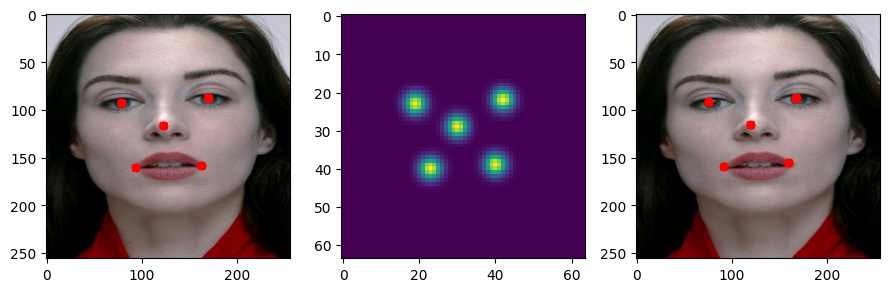

In [31]:
image_index_to_show = 7
_, axes = plt.subplots(1, 3, figsize=(9,3), tight_layout=True)

img = image[image_index_to_show]
img = np.array(img)
img = np.transpose(img, (1, 2, 0)).copy()

landmarks = tuple([list(map(round, xy_coord)) for xy_coord in landmark[image_index_to_show]])

img = add_landmarks(img, landmarks)
axes[0].imshow(img)

heatmaps = heatmap[image_index_to_show].sum(dim=0).numpy()

axes[1].imshow(heatmaps)

converted_landmarks = convert_heatmap2landmark(heatmap[image_index_to_show])

img2 = image[image_index_to_show]
img2 = np.array(img2)
img2 = np.transpose(img2, (1, 2, 0)).copy()

img2 = add_landmarks(img2, converted_landmarks)
axes[2].imshow(img2)

In [32]:
class ComputeLoss:
    """ Базовый расчет лосса.

    Параметры
    ---------
    heatmap_loss : лосс для хит-мапов
    """
    def __init__(self, heatmap_loss=None):
        self.heatmap_loss = nn.MSELoss(reduction='mean') if heatmap_loss is None else heatmap_loss

    def __call__(self, predicts, targets):
        """ Расчет лосса для пары (предсказание, таргет)

        Параметры
        ---------
        predicts : Список предсказания heatmap с каждой головы модели
        targets : Gt значения heatmap'ов ключевых точек
        """

        losses = [self.heatmap_loss(predict, targets) for predict in predicts]
        total_loss = sum(losses)
        return total_loss

In [36]:
class Runner:
    """ Базовый класс для обучения и валидации модели.

    Параметры
    ---------
    model : torch модель, которая будет обучаться.
    compute_loss : экземпляр класса ComputeLoss (или другого с реализованным методом __call__).
    optimizer : torch optimizer
    train_dataloader : torch dataloader семплирующий данные для обучения модели.
    device : девайс на котором будет происходить обучения, по дефолту "cpu"
    scheduler : torch scheduler
    val_dataloader : torch dataloader загружающий валидационные данные.
    val_every : как часто проводить валидацию
    """
    def __init__(self, model, compute_loss, optimizer, train_dataloader, device=DEVICE, scheduler=None,
                 val_dataloader=None, val_every=5):
        self.model = model
        self.compute_loss = compute_loss
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.device = "cpu" if device is None else device
        self.scheduler = scheduler

        # Валидационные параметры
        self.val_dataloader = val_dataloader
        self.val_every = val_every

        # Вспомогательные массивы
        self.batch_loss = []
        self.epoch_loss = []
        self.val_metric = []

    def _run_train_epoch(self, dataloader, verbose=True):
        """ Обучить модель одну эпоху на данных из `dataloader` """
        self.model.train()
        batch_loss = []
        for images, _, _, targets, _ in (pbar := tqdm(dataloader, desc=f"Process train epoch", leave=False)):
            images = images.to(self.device)
            targets = targets.to(self.device)

            outputs = self.model(images)
            loss = self.compute_loss(outputs, targets) / images.shape[0]
            batch_loss.append(loss.detach().cpu().item())

            # Делаем шаг оптимизатора после расчета лосса для всех элементов батча
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        # Обновляем описание tqdm бара усредненным значением лосса за предыдущй батч
            if verbose:
                pbar.set_description(f"Current batch loss: {batch_loss[-1]:.4}")
        return batch_loss

    def train(self, num_epochs=10, verbose=True):
        """ Обучаем модель заданное количество эпох. """
        val_desc = ""
        for epoch in (epoch_pbar := tqdm(range(1, num_epochs+1), desc="Train epoch", total=num_epochs)):
            # Обучаем модель одну эпоху
            loss = self._run_train_epoch(self.train_dataloader, verbose=verbose)
            self.batch_loss.extend(loss)
            self.epoch_loss.append(np.mean(self.batch_loss[-len(self.train_dataloader):]))

            # Делаем валидацию, если был передан валидационный датасет
            if self.val_dataloader is not None and epoch % self.val_every == 0:
                val_metric = self.validate()

                if not self.val_metric or val_metric > max(self.val_metric):
                    torch.save(self.model.state_dict(), f"SHN_stack4_hg4_epoch_{epoch}.weights") # Сохраняем лучшую модель

                self.val_metric.append(val_metric)
                val_desc = f" Val {val_metric}"

            # Обновляем описание tqdm бара усредненным значением лосса за предыдую эпоху
            if verbose:
                epoch_pbar.set_description(f"Last epoch loss: Train {self.epoch_loss[-1]:.4}" + val_desc)
            # Делаем шаг scheduler'a если он был передан
            if self.scheduler is not None:
                self.scheduler.step()


    def validate(self, dataloader=None):
        """ Метод для валидации модели.
        """
        self.model.eval()
        dataloader = self.val_dataloader if dataloader is None else dataloader

        val_metric = []

        with torch.no_grad():
            for images, _, _, targets, _ in tqdm(dataloader, desc="Running validation", leave=False):
                images = images.to(self.device)
                targets = targets.to(self.device)
                outputs = self.model(images)[-1]

                metric = 1 - torch.sqrt(F.mse_loss(outputs.detach().cpu(), targets.detach().cpu()))
                val_metric.append(metric)

        return np.array(val_metric).mean()

    def plot_loss(self, row_figsize=3):
        """ Метод для отрисовки графика обучения.
        """
        nrows = 2 if self.val_metric else 1
        _, ax = plt.subplots(nrows, 1, figsize=(12, row_figsize*nrows), tight_layout=True)
        ax = np.array([ax]) if not isinstance(ax, np.ndarray) else ax
        ax[0].plot(self.batch_loss, label="Train batch Loss", color="tab:blue")
        ax[0].plot(np.arange(1, len(self.batch_loss)+1, len(self.train_dataloader)), self.epoch_loss,
                   color="tab:orange", label="Train epoch Loss")
        ax[0].grid()
        ax[0].set_title("Train Loss")
        ax[0].set_xlabel("Number of Iterations")
        ax[0].set_ylabel("Loss")
        if self.val_metric:
            ax[1].plot(np.arange(self.val_every, (len(self.val_metric)+1) * self.val_every, self.val_every),
                       np.array(self.val_metric) * 100, color="tab:green", label="Validation 1-MSE")
            ax[1].grid()
            ax[1].set_title("Validation MSELoss")
            ax[1].set_xlabel("Number of Iterations")
            ax[1].set_ylabel("1 - MSE")
        plt.legend()
        plt.show()

In [37]:
# Подготавливаем гиперпараметры для запуска обучения
lr = 1e-3
num_epochs = 30

# shn_model
optimizer = optim.Adam(shn_model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=5e-5)

compute_loss = ComputeLoss()

runner = Runner(shn_model, compute_loss, optimizer, train_dataloader, scheduler=scheduler, val_dataloader=val_dataloader, val_every=5)

In [ ]:
# Запустим само обучение модели
if TRAIN:
    torch.cuda.empty_cache()
    runner.train(num_epochs=num_epochs, verbose=True)

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

/tmp/ipython-input-1877942484.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Crop
  A.Crop(


Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation:   0%|          | 0/63 [00:00<?, ?it/s]

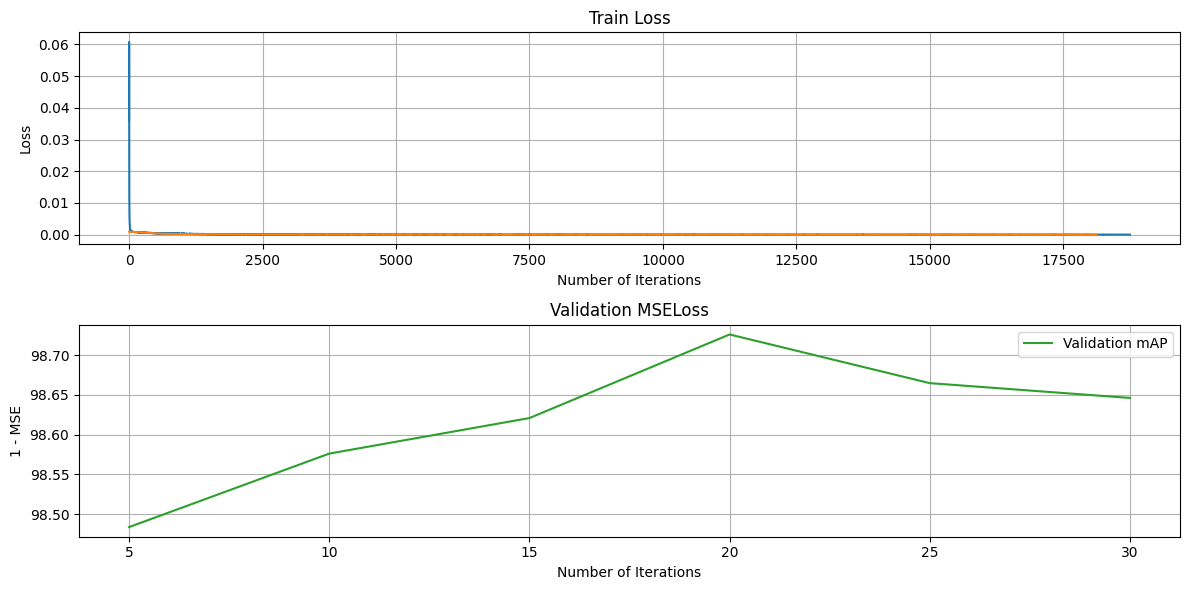

In [ ]:
runner.plot_loss()

In [8]:
# Веса модели можно скачать с Я.Диска (https://disk.yandex.ru/d/bhR7mvA_jrpPvQ, папка 'models')
try:
    shn_model = StackedHourglassNetwork(in_channels=3, num_stacks=4, num_blocks=1, num_heatmaps=5, hourglass_depth=4)
    shn_model.to(DEVICE)
    shn_model.load_state_dict(torch.load("SHN_stack4_hg4_epoch20.weights", weights_only=True, map_location=torch.device('cpu')))
    shn_model.eval()
except FileNotFoundError:
    print("Файл модели не найден!")

Посмотрим как модель научилась предсказывать ключевые точки:

In [39]:
image, bbox, landmark, heatmap, image_id = next(iter(val_dataloader))

pred = shn_model(image.to(DEVICE))[-1]
pred = pred.detach().cpu()

/tmp/ipython-input-4174091519.py:24: UserWarning: Argument(s) 'always_apply' are not valid for transform Crop
  A.Crop(


In [40]:
lm = []
for p in pred:
    lm.append(convert_heatmap2landmark(p))

In [41]:
plot_image_tensor(image, bbox, lm, image_id, num_examples=9)

## Вывод:
Видно, что модель хорошо предсказывает точки на валидационном датасете, который собран из одного и того же основного датасета с идентичными начальными преобразованиями, но с разными картинками.

Подготовим функцию для выравнивания лица:

_Примечание: проверялось использование всех пяти точек, но, видимо из-за излишества связей и граничных условий, преобразования получались крайне не стабильными, поэтому в итоге выбрано преобразование лишь по 3 точкам (глаза и нос)_:

In [42]:
def face_aligner(image, landmarks):

    """
    Выравниваем изображение image с помощью полученных ключевых точек landmarks

    :param image: исходное изображение
    :param landmarks: список ключевых точек
    :return: выравненное изображение
    """

    output_size = (256, 256)

    # Левый глаз
    left_eye = landmarks[0]
    # Правый глаз
    right_eye = landmarks[1]
    # Кончик носа
    nose_tip = landmarks[2]
    # Левый уголок рта
    # mouth_left = landmarks[3]
    # Правый уголок рта
    # mouth_right = landmarks[4]

    # Исходные точки (source points)
    src_points = np.array([
        left_eye,
        right_eye,
        nose_tip,
        # mouth_left,
        # mouth_right
    ], dtype=np.float32)


    # Целевые точки (target points) для выровненного лица
    # Эти координаты основаны на средних пропорциях лица
    output_w, output_h = output_size

    # Координаты для выровненного лица

    target_left_eye = (output_w * 0.30, output_h * 0.35)
    target_right_eye = (output_w * 0.70, output_h * 0.35)
    target_nose = (output_w * 0.50, output_h * 0.55)
    # target_mouth_left = (output_w * 0.30, output_h * 0.65)
    # target_mouth_right = (output_w * 0.70, output_h * 0.65)

    dst_points = np.array([
        target_left_eye,
        target_right_eye,
        target_nose,
        # target_mouth_left,
        # target_mouth_right
    ], dtype=np.float32)

    # Использование RANSAC для нахождения аффинного преобразования
    # (требует минимум 3 точки)
    affine_matrix, inliers = cv2.estimateAffinePartial2D(
        src_points,
        dst_points,
        method=cv2.RANSAC,
        ransacReprojThreshold=3.0
    )

    # Применяем аффинное преобразование
    aligned_face = cv2.warpAffine(
        image,
        affine_matrix,
        output_size,
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_REPLICATE
    )

    return aligned_face, affine_matrix, src_points, dst_points

### Проверка выравнивания

In [43]:
image, bbox, landmark, heatmap, image_id = next(iter(val_dataloader))

/tmp/ipython-input-4174091519.py:24: UserWarning: Argument(s) 'always_apply' are not valid for transform Crop
  A.Crop(


Исходные картинки с предсказанным точками:

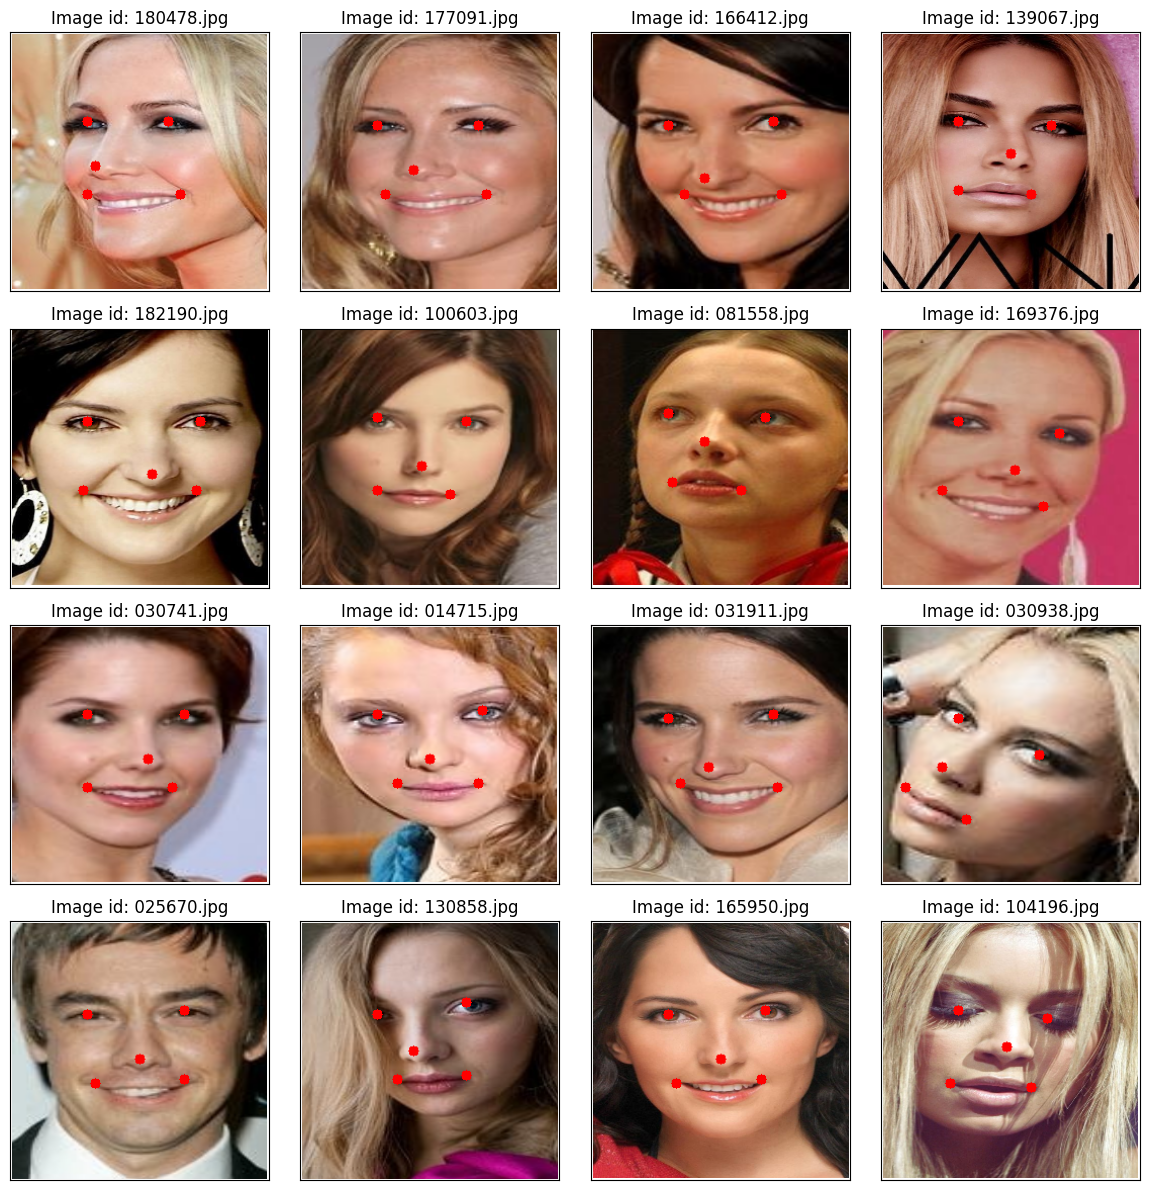

In [44]:
preds = shn_model(image.to(DEVICE))[-1]
preds = preds.detach().cpu()

image_w_landmarks = image.clone()

lm = []
for p in preds:
    lm.append(convert_heatmap2landmark(p))

plot_image_tensor(image_w_landmarks, bbox, lm, image_id, num_examples=16, ncolumns=4)

Выравненные картинки:

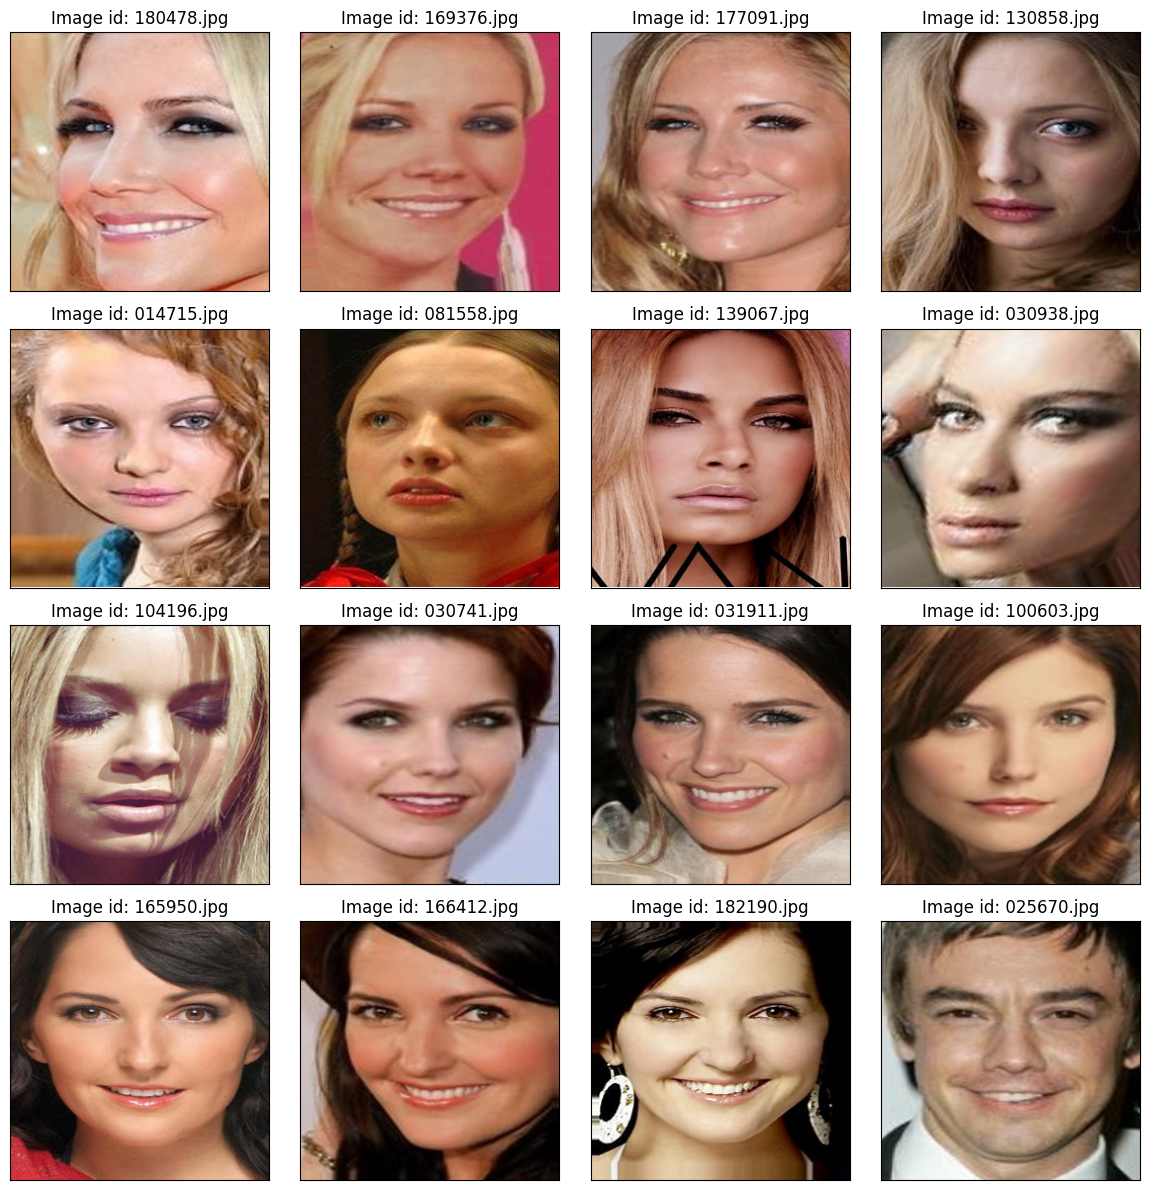

In [ ]:
indices = range(16)
ncols = 4
nrows = 4
_, axes = plt.subplots(nrows, ncols, figsize=(12, 12), tight_layout=True)
axes = axes.reshape(-1)
for ix, ax in zip(indices, axes):
    img = image[ix]
    img = np.array(img)
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0)).copy()

    aligned_face, matrix, src_pts, dst_pts = face_aligner(img, lm[ix])

    aligned_face_landmarked = aligned_face.copy()
    # landmark = tuple([list(map(round, xy_coord)) for xy_coord in dst_pts])
    # aligned_face_landmarked = add_landmarks(aligned_face_landmarked, landmark)

    ax.imshow(aligned_face_landmarked)
    ax.set_title(f"Image id: {image_id[ix]}")
    ax.set_xticks([])
    ax.set_yticks([])

## Выравнивание датасетов


Выравним все датасеты для дальнейшего обучения, валидации и тестирования модели распознавания лиц:

In [46]:
# Веса модели можно скачать с Я.Диска (https://disk.yandex.ru/d/bhR7mvA_jrpPvQ, папка 'models')
try:
    shn_model = StackedHourglassNetwork(in_channels=3, num_stacks=4, num_blocks=1, num_heatmaps=5, hourglass_depth=4)
    shn_model.to(DEVICE)
    shn_model.load_state_dict(torch.load("SHN_stack4_hg4_epoch20.weights", weights_only=True, map_location=torch.device('cpu')))
    shn_model.eval()
except FileNotFoundError:
    print("Файл модели не найден!")

### 1. Тренировочный датасет

In [47]:
image, bbox, landmark, heatmap, image_id = next(iter(train_dataloader))

/tmp/ipython-input-4174091519.py:24: UserWarning: Argument(s) 'always_apply' are not valid for transform Crop
  A.Crop(


In [ ]:
folder_path = './train_dataset_aligned'
os.makedirs(folder_path, exist_ok=True)

for images, _, _, _, image_ids in (pbar := tqdm(train_dataloader, desc=f"Process train dataset", leave=False)):

    images = images.to(DEVICE)
    outputs = shn_model(images)[-1].detach().cpu()

    bs = outputs.shape[0]

    for i in range(bs):

        pred = outputs[i]
        image = images[i].detach().cpu()
        image_id = image_ids[i]

        landmark = convert_heatmap2landmark(pred)

        image = image.numpy()
        image = np.clip(image, 0, 1)
        image = np.transpose(image, (1, 2, 0)).copy()

        aligned_img, _, _, _ = face_aligner(image, landmark)

        save_path = os.path.join(folder_path, image_id)

        rgb_image = cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB)
        rgb_image = (rgb_image * 255).astype(np.int32)

        cv2.imwrite(save_path, rgb_image)

df_train.to_csv("./train_dataset_aligned/train_dataset.csv", index=True)

!zip -r ./train_dataset_aligned.zip ./train_dataset_aligned

Process train dataset:   0%|          | 0/625 [00:00<?, ?it/s]

/tmp/ipython-input-1877942484.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Crop
  A.Crop(


Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: train_dataset_aligned/040766.jpg (deflated 1%)
  adding: train_dataset_aligned/183174.jpg (deflated 1%)
  adding: train_dataset_aligned/121517.jpg (deflated 1%)
  adding: train_dataset_aligned/113588.jpg (deflated 1%)
  adding: train_dataset_aligned/145302.jpg (deflated 1%)
  adding: train_dataset_aligned/117212.jpg (deflated 1%)
  adding: train_dataset_aligned/031383.jpg (deflated 1%)
  adding: train_dataset_aligned/200049.jpg (deflated 1%)
  adding: train_dataset_aligned/167709.jpg (deflated 1%)
  adding: train_dataset_aligned/182202.jpg (deflated 1%)
  adding: train_dataset_aligned/014966.jpg (deflated 1%)
  adding: train_dataset_aligned/152856.jpg (deflated 1%)
  adding: train_dataset_aligned/146002.jpg (deflated 1%)
  adding: train_dataset_aligned/108754.jpg (deflated 1%)
  adding: train_dataset_aligned/043856.jpg (deflated 1%)
  adding: train_dataset_aligned/009428.jpg (deflated 1%)
  adding: train_data

### 2. Валидационный датасет

In [ ]:
image, bbox, landmark, heatmap, image_id = next(iter(val_dataloader))

/tmp/ipython-input-1877942484.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Crop
  A.Crop(


In [ ]:
folder_path = './val_dataset_aligned'
os.makedirs(folder_path, exist_ok=True)

for images, _, _, _, image_ids in (pbar := tqdm(val_dataloader, desc=f"Process val dataset", leave=False)):

    images = images.to(DEVICE)
    outputs = shn_model(images)[-1].detach().cpu()

    bs = outputs.shape[0]

    for i in range(bs):

        pred = outputs[i]
        image = images[i].detach().cpu()
        image_id = image_ids[i]

        landmark = convert_heatmap2landmark(pred)

        image = image.numpy()
        image = np.clip(image, 0, 1)
        image = np.transpose(image, (1, 2, 0)).copy()

        aligned_img, _, _, _ = face_aligner(image, landmark)

        save_path = os.path.join(folder_path, image_id)

        rgb_image = cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB)
        rgb_image = (rgb_image * 255).astype(np.int32)


        cv2.imwrite(save_path, rgb_image)

df_val.to_csv("./val_dataset_aligned/val_dataset.csv", index=True)

!zip -r ./val_dataset_aligned.zip ./val_dataset_aligned

Process val dataset:   0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipython-input-1877942484.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Crop
  A.Crop(


  adding: val_dataset_aligned/ (stored 0%)
  adding: val_dataset_aligned/047774.jpg (deflated 1%)
  adding: val_dataset_aligned/102762.jpg (deflated 1%)
  adding: val_dataset_aligned/199815.jpg (deflated 1%)
  adding: val_dataset_aligned/106660.jpg (deflated 1%)
  adding: val_dataset_aligned/123030.jpg (deflated 1%)
  adding: val_dataset_aligned/118588.jpg (deflated 1%)
  adding: val_dataset_aligned/068243.jpg (deflated 1%)
  adding: val_dataset_aligned/188022.jpg (deflated 1%)
  adding: val_dataset_aligned/084325.jpg (deflated 1%)
  adding: val_dataset_aligned/196502.jpg (deflated 1%)
  adding: val_dataset_aligned/038112.jpg (deflated 1%)
  adding: val_dataset_aligned/032296.jpg (deflated 1%)
  adding: val_dataset_aligned/096766.jpg (deflated 1%)
  adding: val_dataset_aligned/113573.jpg (deflated 1%)
  adding: val_dataset_aligned/037104.jpg (deflated 1%)
  adding: val_dataset_aligned/196180.jpg (deflated 1%)
  adding: val_dataset_aligned/194581.jpg (deflated 1%)
  adding: val_dataset_

### 3. Тестовый датасет

In [ ]:
# Загрузка тестового датасета
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/_DvpJqwXWcEyGg) -o test_dataset.zip
! unzip -qq test_dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 35.9M  100 35.9M    0     0  5048k      0  0:00:07  0:00:07 --:--:-- 9051k


In [ ]:
df_test = pd.read_csv('./test_dataset/test_dataset.csv', index_col=False)
df_test.sample(5)

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
375  009645.jpg                -1               -1          -1   
314  156771.jpg                -1               -1           1   
168  082796.jpg                -1                1           1   
102  160329.jpg                -1               -1          -1   
341  158021.jpg                 1               -1           1   

     Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
375               -1    -1      1        -1        -1          -1  ...   
314               -1    -1     -1        -1         1          -1  ...   
168               -1    -1     -1        -1        -1          -1  ...   
102               -1    -1     -1        -1        -1           1  ...   
341               -1    -1     -1        -1        -1           1  ...   

     lefteye_y  righteye_x  righteye_y  nose_x  nose_y  leftmouth_x  \
375        207         208         203     173     263          145   
314        931        1124         906     921    1193          768   
168        198         224         210     189     239          142   
102        167         312         179     300     209          264   
341        140         172         135     145     169          134   

     leftmouth_y  rightmouth_x  rightmouth_y    set_type  
375          283           208           284  distractor  
314         1370          1104          1346  distractor  
168          261           210           271  distractor  
102          245           298           250       query  
341          192           178           179  distractor  

[5 rows x 57 columns]

In [ ]:
df_q_test = df_test[df_test['set_type'] == 'query']

test_q_dataset = FaceDataset(df_q_test, root_folder='./test_dataset/query/')
test_q_dataloader = DataLoader(test_q_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
image, bbox, landmark, heatmap, image_id = next(iter(test_q_dataloader))

/tmp/ipython-input-1877942484.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Crop
  A.Crop(


In [ ]:
folder_path = './test_dataset_aligned/query'
os.makedirs(folder_path, exist_ok=True)

for images, _, _, _, image_ids in (pbar := tqdm(test_q_dataloader, desc=f"Process test q dataset", leave=False)):

    images = images.to(DEVICE)
    outputs = shn_model(images)[-1].detach().cpu()

    bs = outputs.shape[0]

    for i in range(bs):

        pred = outputs[i]
        image = images[i].detach().cpu()
        image_id = image_ids[i]

        landmark = convert_heatmap2landmark(pred)

        image = image.numpy()
        image = np.clip(image, 0, 1)
        image = np.transpose(image, (1, 2, 0)).copy()

        aligned_img, _, _, _ = face_aligner(image, landmark)

        # Define the full path to save the image
        save_path = os.path.join(folder_path, image_id)

        rgb_image = cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB)
        rgb_image = (rgb_image * 255).astype(np.int32)


        cv2.imwrite(save_path, rgb_image)



Process test q dataset:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipython-input-1877942484.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Crop
  A.Crop(


In [ ]:
df_d_test = df_test[df_test['set_type'] == 'distractor']

test_d_dataset = FaceDataset(df_d_test, root_folder='./test_dataset/distractor/')
test_d_dataloader = DataLoader(test_d_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
image, bbox, landmark, heatmap, image_id = next(iter(test_d_dataloader))

/tmp/ipython-input-1877942484.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Crop
  A.Crop(


In [ ]:
folder_path = './test_dataset_aligned/distractor'
os.makedirs(folder_path, exist_ok=True)

for images, _, _, _, image_ids in (pbar := tqdm(test_d_dataloader, desc=f"Process test d dataset", leave=False)):

    images = images.to(DEVICE)
    outputs = shn_model(images)[-1].detach().cpu()

    bs = outputs.shape[0]

    for i in range(bs):

        pred = outputs[i]
        image = images[i].detach().cpu()
        image_id = image_ids[i]

        landmark = convert_heatmap2landmark(pred)

        image = image.numpy()
        image = np.clip(image, 0, 1)
        image = np.transpose(image, (1, 2, 0)).copy()

        aligned_img, _, _, _ = face_aligner(image, landmark)

        save_path = os.path.join(folder_path, image_id)

        rgb_image = cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB)
        rgb_image = (rgb_image * 255).astype(np.int32)


        cv2.imwrite(save_path, rgb_image)

Process test d dataset:   0%|          | 0/22 [00:00<?, ?it/s]

/tmp/ipython-input-1877942484.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Crop
  A.Crop(


In [ ]:
df_test.to_csv("./test_dataset_aligned/test_dataset.csv", index=True)

!zip -r ./test_dataset_aligned.zip ./test_dataset_aligned

  adding: test_dataset_aligned/ (stored 0%)
  adding: test_dataset_aligned/distractor/ (stored 0%)
  adding: test_dataset_aligned/distractor/033179.jpg (deflated 1%)
  adding: test_dataset_aligned/distractor/159468.jpg (deflated 1%)
  adding: test_dataset_aligned/distractor/144401.jpg (deflated 1%)
  adding: test_dataset_aligned/distractor/102359.jpg (deflated 1%)
  adding: test_dataset_aligned/distractor/076045.jpg (deflated 1%)
  adding: test_dataset_aligned/distractor/014806.jpg (deflated 1%)
  adding: test_dataset_aligned/distractor/133813.jpg (deflated 1%)
  adding: test_dataset_aligned/distractor/134794.jpg (deflated 1%)
  adding: test_dataset_aligned/distractor/048217.jpg (deflated 1%)
  adding: test_dataset_aligned/distractor/116582.jpg (deflated 1%)
  adding: test_dataset_aligned/distractor/002417.jpg (deflated 1%)
  adding: test_dataset_aligned/distractor/159609.jpg (deflated 1%)
  adding: test_dataset_aligned/distractor/076165.jpg (deflated 1%)
  adding: test_dataset_aligned